<h1>ECE521 Assignment 3</h1>

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

<h2>Utils</h2>

In [11]:
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.
     
     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(input_tensor, 
                                    reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, 
                                       reduction_indices) 
  return tf.log(tf.reduce_sum(tf.exp(input_tensor - max_input_tensor2), 
                                reduction_indices, keep_dims=keep_dims)) + max_input_tensor1

def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     
 
  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, keep_dims=True)

<h2>1</h2>

<h3>1.1.2</h3>

In [51]:
data = np.load("../data/data2D.npy")
points_2d = data
print(data)

[[ 1.69424762 -2.4385797 ]
 [ 1.12750805 -2.06013747]
 [ 2.40075462 -2.96636567]
 ..., 
 [-1.11873012 -3.41074163]
 [ 1.58777283  0.14010238]
 [ 1.36922966  0.26141621]]


In [176]:
def buildGraph_K_means_Adam(K, learning_rate):
    # Variable creation
    points = tf.placeholder(tf.float32, [None, 2], name='input_points')
    centroids = tf.Variable(tf.truncated_normal(shape=[K,2], stddev=0.5), name='centroids')
    N = tf.shape(points)[0]
    # Replicate to N copies of each centroid and K copies of each
    # point, then subtract and compute the sum of squared distances.
    rep_centroids = tf.reshape(tf.tile(centroids, [N, 1]), [N, K, 2])
    rep_points = tf.reshape(tf.tile(points, [1, K]), [N, K, 2])
    sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), reduction_indices=2)
    best_centroids = tf.argmin(sum_squares, 1)
    count = tf.to_float(tf.unsorted_segment_sum(tf.ones_like(points), best_centroids, K))
    percentage = tf.div(count, tf.to_float(N))
    # Loss definition
    indices_pair = tf.concat(1, [tf.reshape(tf.range(0, N), [-1,1]), tf.to_int32(tf.reshape(best_centroids, [-1,1]))])
    loss = tf.reduce_sum(tf.gather_nd(sum_squares, indices_pair))
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-5)
    train = optimizer.minimize(loss=loss)
    return points, centroids, best_centroids, loss, percentage, train

In [150]:
a = tf.constant([[1,1],[0,0],[1,0]])
b = tf.constant([1,0,1])
indices_pair = tf.reshape(tf.range(0, 3), [-1,1])
concated = tf.concat(1, [indices_pair, tf.reshape(b, [-1,1])])
#concated = tf.reshape(concated, [-1,2])
sess.run(concated)

array([[0, 1],
       [1, 0],
       [2, 1]])

In [39]:
Number_of_data = points_2d.shape[0]
# fix figure size
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


Iteration#: 0, loss: 50975.85
Iteration#: 100, loss: 20884.33
Iteration#: 200, loss: 10851.50
Iteration#: 300, loss: 7027.50
Iteration#: 400, loss: 5497.18


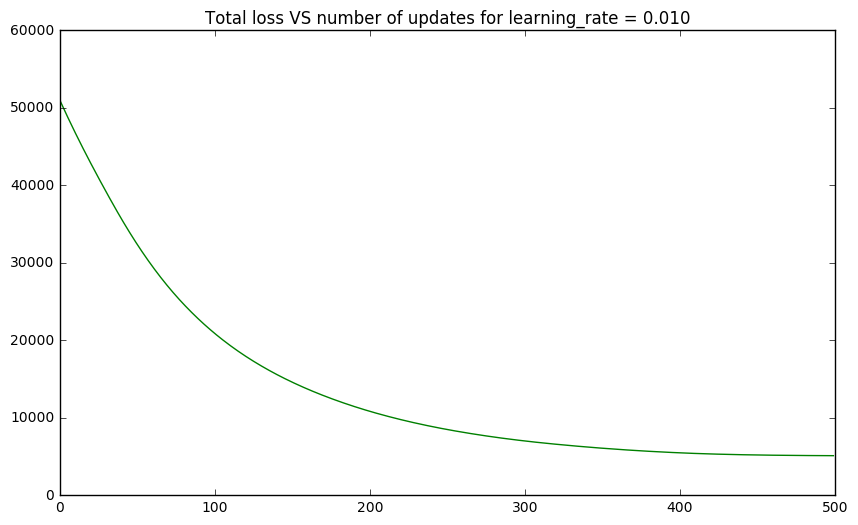

In [177]:
learning_rate = 0.01
points, centroids, centroids_assign, loss, percentage, train = buildGraph_K_means_Adam(3, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
loss_recorder = np.array([])

numIteration = 500
for itr in range(numIteration):
    loss_, _ = sess.run([loss, train], feed_dict={points: points_2d})
    loss_recorder = np.append(loss_recorder, loss_)
    if itr % 100 == 0:
        print("Iteration#: %d, loss: %0.2f"%(itr, loss_))
plt.plot(np.arange(numIteration), loss_recorder, 'g')
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

<h3>1.1.3</h3>

Number of cluster: 1, loss: 52017.54
Number of cluster: 1, loss: 39568.55
Number of cluster: 1, loss: 38459.06
Number of cluster: 1, loss: 38453.48
Number of cluster: 1, loss: 38453.49
Number of cluster: 1, loss: 38453.49
Number of cluster: 1, loss: 38453.49
Number of cluster: 1, loss: 38453.49
Number of cluster: 1, loss: 38453.48
Number of cluster: 1, loss: 38453.48
Percentage for different clusters:
Total K is 1, cluster 0: 1.00


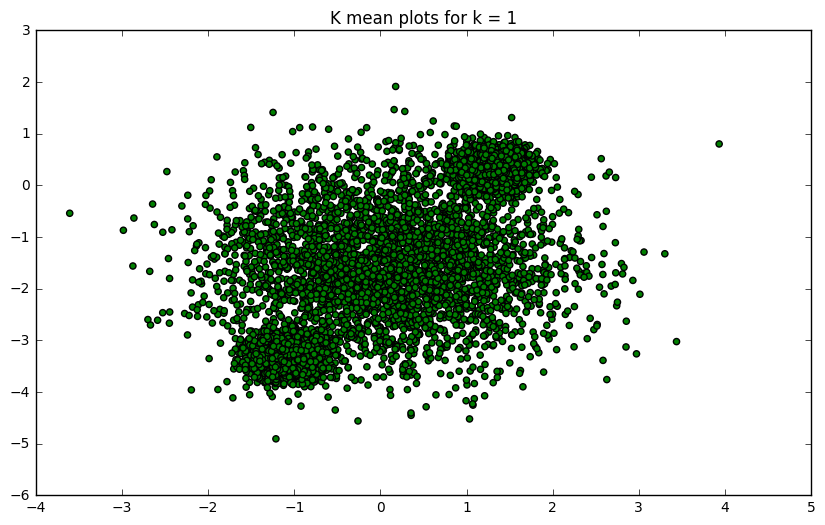

Number of cluster: 2, loss: 48285.62
Number of cluster: 2, loss: 20486.51
Number of cluster: 2, loss: 11164.94
Number of cluster: 2, loss: 9406.37
Number of cluster: 2, loss: 9210.05
Number of cluster: 2, loss: 9203.37
Number of cluster: 2, loss: 9203.35
Number of cluster: 2, loss: 9203.35
Number of cluster: 2, loss: 9203.35
Number of cluster: 2, loss: 9203.35
Percentage for different clusters:
Total K is 2, cluster 0: 0.50
Total K is 2, cluster 1: 0.50


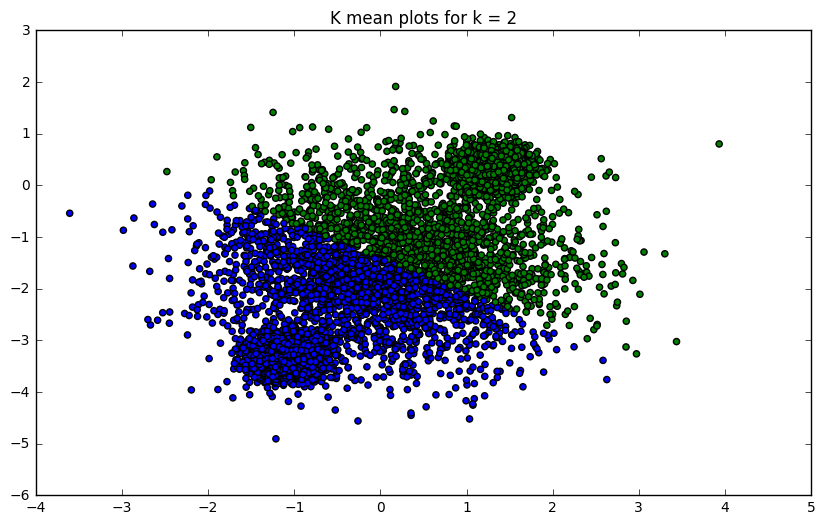

Number of cluster: 3, loss: 64090.91
Number of cluster: 3, loss: 30813.88
Number of cluster: 3, loss: 16085.63
Number of cluster: 3, loss: 8298.10
Number of cluster: 3, loss: 6071.78
Number of cluster: 3, loss: 5233.04
Number of cluster: 3, loss: 5113.93
Number of cluster: 3, loss: 5111.07
Number of cluster: 3, loss: 5111.07
Number of cluster: 3, loss: 5111.07
Percentage for different clusters:
Total K is 3, cluster 0: 0.38
Total K is 3, cluster 1: 0.24
Total K is 3, cluster 2: 0.38


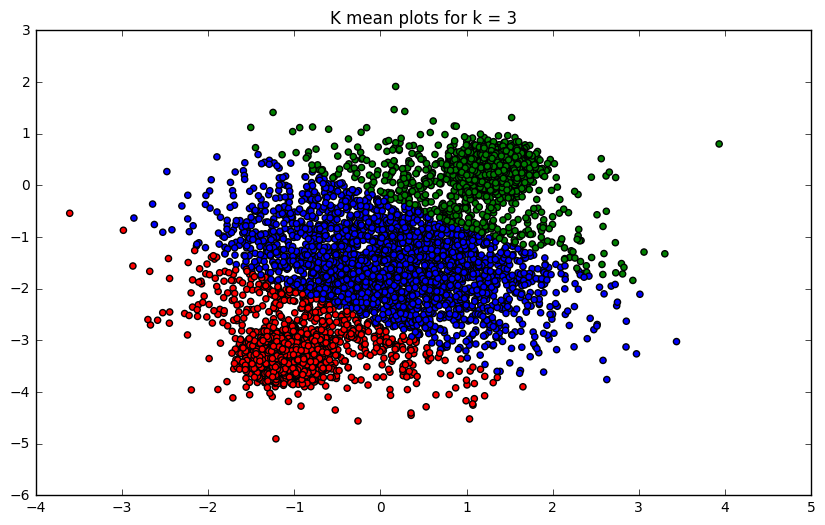

Number of cluster: 4, loss: 49048.83
Number of cluster: 4, loss: 21290.50
Number of cluster: 4, loss: 9163.80
Number of cluster: 4, loss: 5035.14
Number of cluster: 4, loss: 3639.95
Number of cluster: 4, loss: 3387.48
Number of cluster: 4, loss: 3374.06
Number of cluster: 4, loss: 3374.03
Number of cluster: 4, loss: 3374.03
Number of cluster: 4, loss: 3374.03
Percentage for different clusters:
Total K is 4, cluster 0: 0.13
Total K is 4, cluster 1: 0.37
Total K is 4, cluster 2: 0.37
Total K is 4, cluster 3: 0.12


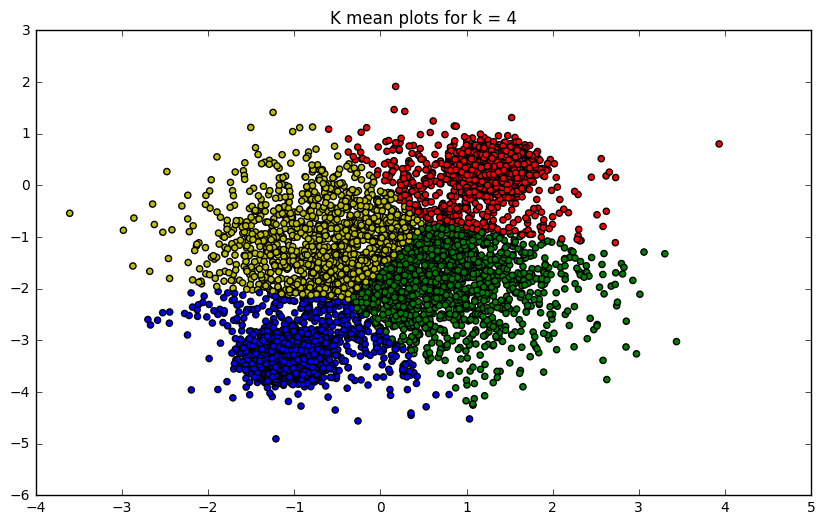

Number of cluster: 5, loss: 39798.93
Number of cluster: 5, loss: 14164.03
Number of cluster: 5, loss: 6206.73
Number of cluster: 5, loss: 3522.39
Number of cluster: 5, loss: 2934.20
Number of cluster: 5, loss: 2879.84
Number of cluster: 5, loss: 2870.63
Number of cluster: 5, loss: 2870.63
Number of cluster: 5, loss: 2870.63
Number of cluster: 5, loss: 2870.63
Percentage for different clusters:
Total K is 5, cluster 0: 0.07
Total K is 5, cluster 1: 0.37
Total K is 5, cluster 2: 0.08
Total K is 5, cluster 3: 0.37
Total K is 5, cluster 4: 0.11


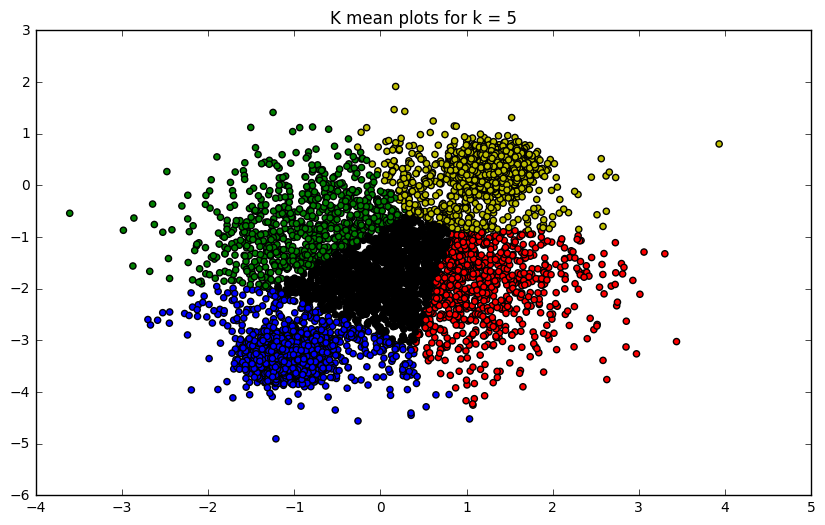

In [180]:
K_list = [1, 2, 3, 4, 5]
learning_rate = 0.01
color_list = ["g", "b", "r", "y", "k"]
for K in K_list:
    points, centroids, centroids_assign, loss, percentage, train = buildGraph_K_means_Adam(K, learning_rate)
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])

    numIteration = 1000
    P = []
    assign = []
    for itr in range(numIteration):
        loss_, P, assign, _ = sess.run([loss, percentage, centroids_assign, train], feed_dict={points: points_2d})
        loss_recorder = np.append(loss_recorder, loss_)
        if itr % 100 == 0:
            print("Number of cluster: %d, loss: %0.2f"%(K, loss_))
    print("Percentage for different clusters:")
    for k in range(K):
        print("Total K is %d, cluster %d: %0.2f"%(K, k, P[k][0])) 
    x = points_2d[:,0]
    y = points_2d[:,1]
    colors = [color_list[assign[x]] for x in range(Number_of_data)]
    plt.scatter(x,y,c=colors)
    #plt.axis([0,500, 0, 2])
    plt.title("K mean plots for k = %d"%(K))
    plt.show()

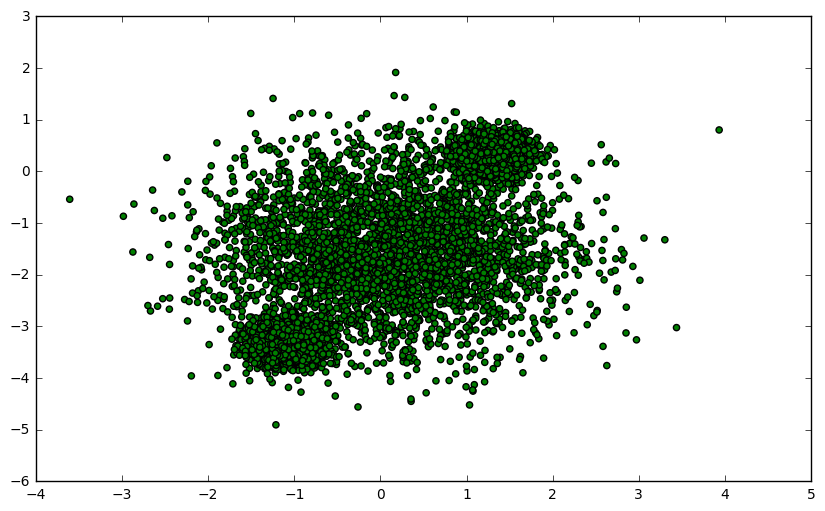

In [85]:
x = points_2d[:,0]
y = points_2d[:,1]
colors = ["g" for x in points_2d[:,0]]
plt.scatter(x,y,c=colors)

<h3>1.1.4</h3>

In [159]:
validSize = int(Number_of_data * 1.0 / 3.0)
validData = points_2d[:validSize,:]
trainData = points_2d[validSize:,:]
print(validData)

[[ 1.69424762 -2.4385797 ]
 [ 1.12750805 -2.06013747]
 [ 2.40075462 -2.96636567]
 ..., 
 [ 1.34861077  0.21586008]
 [-0.33089382 -2.13849022]
 [ 1.47810309  0.71745904]]


Number of cluster: 1, Iteration#: 0, Validation loss: 21494.57
Number of cluster: 1, Iteration#: 100, Validation loss: 14248.43
Number of cluster: 1, Iteration#: 200, Validation loss: 12833.39
Number of cluster: 1, Iteration#: 300, Validation loss: 12752.72
Number of cluster: 1, Iteration#: 400, Validation loss: 12753.20


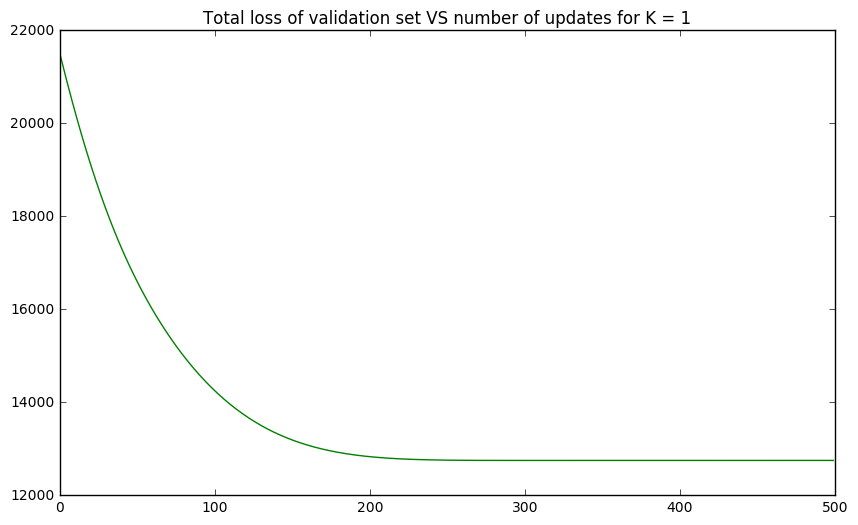

Number of cluster: 2, Iteration#: 0, Validation loss: 18969.51
Number of cluster: 2, Iteration#: 100, Validation loss: 8136.72
Number of cluster: 2, Iteration#: 200, Validation loss: 4489.36
Number of cluster: 2, Iteration#: 300, Validation loss: 3320.94
Number of cluster: 2, Iteration#: 400, Validation loss: 3050.72


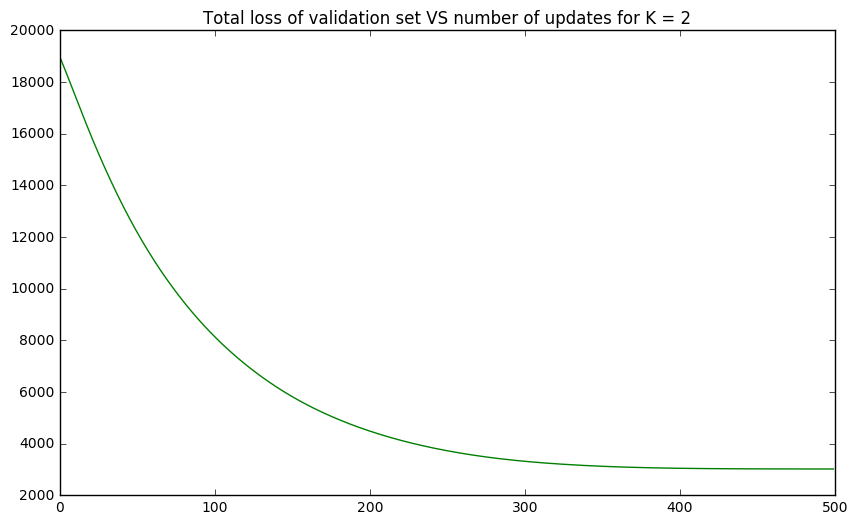

Number of cluster: 3, Iteration#: 0, Validation loss: 15694.48
Number of cluster: 3, Iteration#: 100, Validation loss: 6860.39
Number of cluster: 3, Iteration#: 200, Validation loss: 3233.75
Number of cluster: 3, Iteration#: 300, Validation loss: 2172.90
Number of cluster: 3, Iteration#: 400, Validation loss: 1729.28


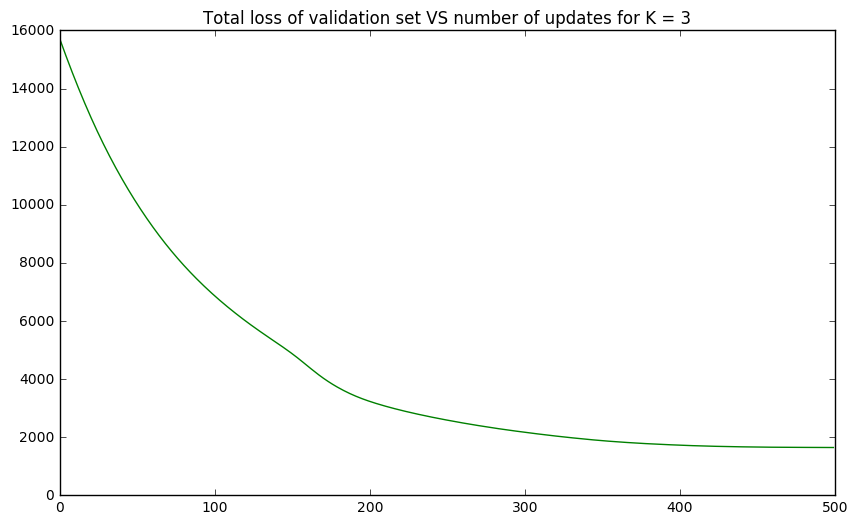

Number of cluster: 4, Iteration#: 0, Validation loss: 12580.76
Number of cluster: 4, Iteration#: 100, Validation loss: 5048.21
Number of cluster: 4, Iteration#: 200, Validation loss: 2290.29
Number of cluster: 4, Iteration#: 300, Validation loss: 1362.81
Number of cluster: 4, Iteration#: 400, Validation loss: 1131.13


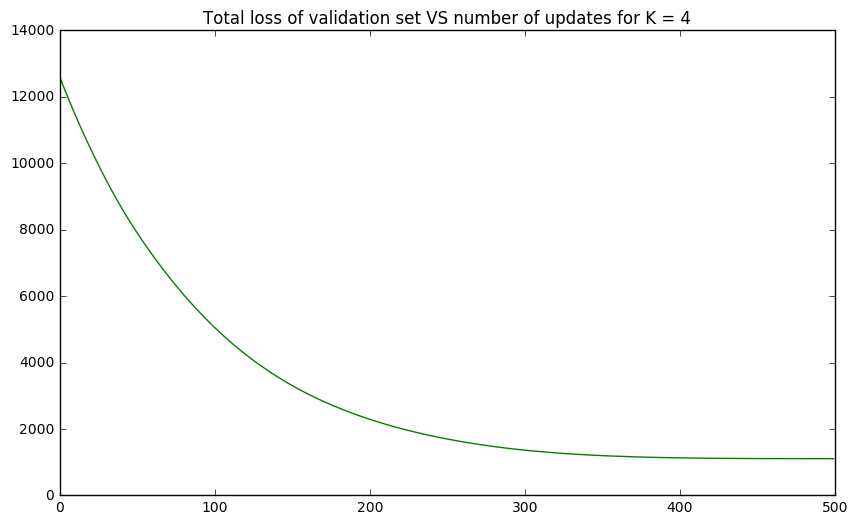

Number of cluster: 5, Iteration#: 0, Validation loss: 15599.42
Number of cluster: 5, Iteration#: 100, Validation loss: 6321.72
Number of cluster: 5, Iteration#: 200, Validation loss: 2709.74
Number of cluster: 5, Iteration#: 300, Validation loss: 1407.25
Number of cluster: 5, Iteration#: 400, Validation loss: 1019.40


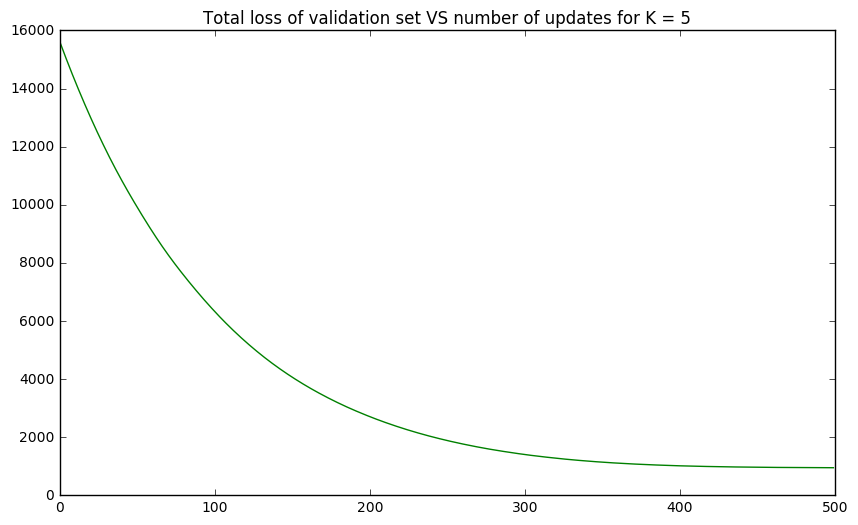

In [186]:
K_list = [1, 2, 3, 4, 5]
learning_rate = 0.01
color_list = ["g", "b", "r", "y", "k"]
for K in K_list:
    points, centroids, centroids_assign, loss, percentage, train = buildGraph_K_means_Adam(K, learning_rate)
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])
    
    numIteration = 500
    for itr in range(numIteration):
        _ = sess.run([train], feed_dict={points: trainData})
        loss_ = sess.run(loss, feed_dict={points: validData})
        loss_recorder = np.append(loss_recorder, loss_)
        if itr % 100 == 0:
            print("Number of cluster: %d, Iteration#: %d, Validation loss: %0.2f"%(K, itr, loss_))
    plt.plot(np.arange(numIteration), loss_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Total loss of validation set VS number of updates for K = %d"%(K))
    plt.show()